In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Lambda, Cropping2D, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.model_selection import train_test_split

from random import shuffle
import math

Using TensorFlow backend.


In [2]:
def get_lines(path):
    lines = []

    with open('./' + path + '/driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            lines.append(line)
    return lines

In [3]:
def generator(samples, batch_size=32,path = 'data2'):
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for i, batch_sample in enumerate(batch_samples):
                for i in range(3):
                    
                    path = './data2/IMG/'
                    file_name = path + batch_sample[i].split('\\')[-1]

                    image = cv2.imread(file_name)
                    image = cv2.resize(image, (200,160))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    measurement = float(batch_sample[i + 3])
                    correction = 0.2
                    if i == 1:
                        measurement += correction
                    elif i == 2:
                        measurement -= correction

                    images.append(image)
                    measurements.append(measurement)
                    images.append(cv2.flip(image,1))
                    measurements.append(measurement*-1.0)
                        
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [4]:
def get_conv_norm_layer(out, ksize, strides):
    layer = Sequential()
    layer.add(Conv2D(out,(ksize,ksize),strides = (strides,strides), activation='relu'))
    layer.add(BatchNormalization())
    return layer

In [5]:
def get_model():
    import cv2
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5 ,input_shape = (160,200,3)))
    model.add(Cropping2D(cropping = ((70, 24),(0,0))))
    model.add(Conv2D(24,(5,5),strides = (2,2), activation='relu'))
    model.add(Conv2D(36,(5,5),strides = (2,2), activation='relu'))
    model.add(Conv2D(48,(5,5),strides = (2,2), activation='relu'))
    model.add(Conv2D(64,(3,3),strides = (1,1), activation='relu'))
    model.add(Conv2D(64,(3,3),strides = (1,1), activation='relu'))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    return model

def get_model2():
    #import keras
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5 ,input_shape = (160,200,3)))
    model.add(Cropping2D(cropping = ((70, 24),(0,0))))
    model.add(get_conv_norm_layer(24,5,2))
    model.add(get_conv_norm_layer(36,5,2))
    model.add(get_conv_norm_layer(48,5,2))
    model.add(get_conv_norm_layer(64,3,1))
    model.add(get_conv_norm_layer(64,3,2))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))

    return model

In [6]:
lines = get_lines('data2')
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [7]:
batch_size = 32
train_generator = generator(train_samples, batch_size=batch_size, path='data2')
validation_generator = generator(validation_samples, batch_size=batch_size, path= 'data2')

In [8]:
model = get_model2()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 200, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 66, 200, 3)        0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 31, 98, 24)        1920      
_________________________________________________________________
sequential_3 (Sequential)    (None, 14, 47, 36)        21780     
_________________________________________________________________
sequential_4 (Sequential)    (None, 5, 22, 48)         43440     
_________________________________________________________________
sequential_5 (Sequential)    (None, 3, 20, 64)         27968     
_________________________________________________________________
sequ

In [9]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=0)

checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='model.h5',monitor='val_loss',
                                                      verbose=0, save_best_only=True, save_weights_only=False,)

scheduler_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                                                       verbose=1, cooldown=0, min_lr=0)

callbacks = [early_stopping_callback, checkpoint_callback, scheduler_callback]

In [10]:
epochs = 20
model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit_generator(train_generator, steps_per_epoch = math.ceil(len(train_samples) / batch_size),
                                     validation_data = validation_generator, validation_steps=int(len(validation_samples)/ batch_size),
                                     epochs=epochs, verbose=1, callbacks = callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
90/90 [==============================] - 26s 291ms/step - loss: 0.1754 - val_loss: 0.1359
Epoch 2/20
90/90 [==============================] - 21s 229ms/step - loss: 0.0938 - val_loss: 0.0938
Epoch 3/20
90/90 [==============================] - 21s 236ms/step - loss: 0.0771 - val_loss: 0.0999
Epoch 4/20
90/90 [==============================] - 21s 233ms/step - loss: 0.0648 - val_loss: 0.0882
Epoch 5/20
90/90 [==============================] - 21s 233ms/step - loss: 0.0529 - val_loss: 0.0881
Epoch 6/20
90/90 [==============================] - 21s 236ms/step - loss: 0.0421 - val_loss: 0.0888
Epoch 7/20
90/90 [==============================] - 21s 233ms/step - loss: 0.0305 - val_loss: 0.0768
Epoch 8/20
90/90 [==============================] - 21s 233ms/step - loss: 0.0235 - val_loss: 0.0745
Epoch 9/20
90/90 [==============================] - 21s 237ms/step - loss: 0.0188 - val_loss: 0.0744
Epoch 10/20
90/90 [========================

dict_keys(['val_loss', 'loss', 'lr'])


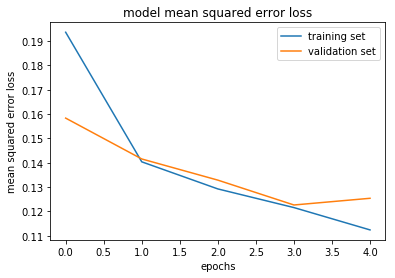

In [17]:
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epochs')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()